<h1 align=middle> Data Science Project </h1>

<h3 align=middle> by Benjamin Chissico </h3>

In [1]:
import pandas as pd 
import numpy as np 
import pathlib 
import matplotlib.pyplot as plt 
from ydata_profiling import ProfileReport
import seaborn as sns 
import json 
plt.style.use("ggplot")
from IPython.display import display
from itertools import permutations

# sklearn stuff 
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier




## The DataSet

Name: reMTPL2freq  
URL: https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq


![ColumnDesc](./misc/data.png)

## Binary Classification 

The Data contains information about the number of claims during a exposure period.  
We want to figure out based on that dataset if we can predict if a driver, based on the information given is likely to claim or not.  
Therefore, each time we see in a row a ClaimNb higher than 0, we automatically label it as 0 and everything will be labelled as 1.  
0 ... no claim so far 
1 ... at least 1 claim so far


## Current Notebook 

The current notebook is the EDA (explorative data analysis) of the data set. 
We will explore the following topics:

- Duplicates 
- Null Values & Unique Values
- Data Types

- Correlations of fields 
- Statistics of the fields, e.g. counts, distinct counts 


## Next Steps 

The next steps will be the transformation and cleaning of the data to extract features that can actually help to classify the binary problem mentioned above. 
Furthermore, we drop the `IDpol` column because its just an ID column without any significance 


![LetsGetStarted](https://thumbs.dreamstime.com/z/lets-get-started-written-blackboard-49967712.jpg)







In [2]:
# data load 
df = pd.read_csv("./data/data.csv")

In [3]:
# Transform the "ClaimNb" field to reflect the binary problem we want to solve later on 
df['Y'] = (df['ClaimNb'] > 0).astype(int)

# drop the ClaimNb field its not needed anymore 
df = df.drop(['ClaimNb','IDpol'],axis=1)
df.head()

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Y
0,0.10,D,5,0,55,50,B12,Regular,1217,R82,1
1,0.77,D,5,0,55,50,B12,Regular,1217,R82,1
2,0.75,B,6,2,52,50,B12,Diesel,54,R22,1
3,0.09,B,7,0,46,50,B12,Diesel,76,R72,1
4,0.84,B,7,0,46,50,B12,Diesel,76,R72,1


### Duplicates 

- Check each whole row for duplicates, if too many rows have duplicates then drop them 

In [4]:
if df[df.duplicated()].empty:
    print("No Duplicates found, so we don't need to do anything ;) The first win!")
else:
    print("Lets have a closer look on how much of the dataframe are duplicates")

Lets have a closer look on how much of the dataframe are duplicates


## Null Values & Unique Values

- Check each column for null values 
- If too much null values are found in a column, think about the possiblity to drop it
- check unique values, if we find a field that only contains 1 unique value, we drop it because its not providing any additional information 

In [5]:
# checking null values
print("No Null Values found in the dataset, another win ;)")
display(
    df.isnull().sum().reset_index().rename(columns={'index':'columnName',0:'noOfOccurrences'}).sort_values(by=['noOfOccurrences'],ascending = False ))

No Null Values found in the dataset, another win ;)


,columnName,noOfOccurrences
0,Exposure,0
1,Area,0
2,VehPower,0
3,VehAge,0
4,DrivAge,0
5,BonusMalus,0
6,VehBrand,0
7,VehGas,0
8,Density,0
9,Region,0


In [6]:
# checking unique values 
for column in df.columns.tolist():
    if column == "Y":
        #skipping the target column 
        continue 
    
    unique_values = df.loc[:,column].unique()
    print(f"Analysing: {column}")
    print(f"\tContains: {len(unique_values):,}")
    if len(unique_values) <= 1:
        print(f"\tAccording to rule, we will drop the column")
        df = df.drop(column,axis=1)
    
    
    
    

Analysing: Exposure
	Contains: 187
Analysing: Area
	Contains: 6
Analysing: VehPower
	Contains: 12
Analysing: VehAge
	Contains: 78
Analysing: DrivAge
	Contains: 83
Analysing: BonusMalus
	Contains: 115
Analysing: VehBrand
	Contains: 11
Analysing: VehGas
	Contains: 2
Analysing: Density
	Contains: 1,607
Analysing: Region
	Contains: 22


### Data Types

- check the current data types 
- check if we can change data types to more appropriate ones, e.g., object to category 

In [9]:
data_types = df.dtypes.reset_index().rename(columns={'index':'columnName',0:'dataType'})
data_types

,columnName,dataType
0,Exposure,float64
1,Area,object
2,VehPower,int64
3,VehAge,int64
4,DrivAge,int64
5,BonusMalus,int64
6,VehBrand,object
7,VehGas,category
8,Density,int64
9,Region,object


Okay, we can see that there are a few "object" data types in the dataset, lets have a closer look to see if one of those values could be a "category". 
For our use case we assume that a category has less than **5** different values 

In [8]:
object_columns = df.select_dtypes(include='object').columns

for column in object_columns:
    print(f"Checking Column: {column!r}")
    unique_values = df.loc[:,column].unique()
    print(f"\t# Unique Values: {len(unique_values):,}")
    if len(unique_values) <= 5:
        print(f"\tWill be transformed into a category!")
        df[column] = df[column].astype('category')

print("\n\nTransformation of Columns is completed, the new data types:\n")
display(df.dtypes)

Checking Column: 'Area'
	# Unique Values: 6
Checking Column: 'VehBrand'
	# Unique Values: 11
Checking Column: 'VehGas'
	# Unique Values: 2
	Will be transformed into a category!
Checking Column: 'Region'
	# Unique Values: 22


Transformation of Columns is completed, the new data types:



Exposure       float64
Area            object
VehPower         int64
VehAge           int64
DrivAge          int64
BonusMalus       int64
VehBrand        object
VehGas        category
Density          int64
Region          object
Y                int32
dtype: object

#### Correlation of Fields 

- calculate the correlation between each field
- visualize the correlation in a heatmap 
- visualize the correlation dataframe with some highlights to see "high" or "low" correlations more easily 


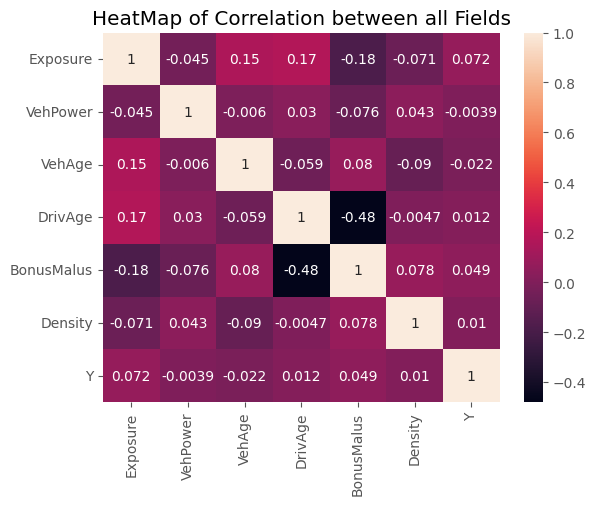

'Its worth noting that the correlation on the \nfirst glance do not look too extreme.\nThe BonusMalus seems to correlate with the DrivAge negatively. Which makes sense\n\nmost younger drivers would start with a higher BonusMalus'

In [10]:
corr = df.corr(numeric_only=True)

ax = sns.heatmap(corr,annot=True)
ax.set_title("HeatMap of Correlation between all Fields")
plt.show()
display("""Its worth noting that the correlation on the 
first glance do not look too extreme.\nThe BonusMalus seems to correlate with the DrivAge negatively. Which makes sense\n
most younger drivers would start with a higher BonusMalus""")

In [11]:
high = .4
low = -.4
color = lambda cell : 'color:darkblue' if cell >=high else 'color:red' if cell <low  else 'color:black'
display(corr.style.applymap(color))
print(f"We can change the high & low values of the correlation which is interesting to us.\nCurrent used Values are high({high}), low({low})")




,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Y
Exposure,1.000000,-0.045259,0.151554,0.171873,-0.183018,-0.071085,0.071779
VehPower,-0.045259,1.000000,-0.006001,0.030108,-0.075895,0.042901,-0.003920
VehAge,0.151554,-0.006001,1.000000,-0.059213,0.079923,-0.090428,-0.021988
DrivAge,0.171873,0.030108,-0.059213,1.000000,-0.479966,-0.004700,0.012100
BonusMalus,-0.183018,-0.075895,0.079923,-0.479966,1.000000,0.077717,0.049069
Density,-0.071085,0.042901,-0.090428,-0.004700,0.077717,1.000000,0.010123
Y,0.071779,-0.003920,-0.021988,0.012100,0.049069,0.010123,1.000000


We can change the high & low values of the correlation which is interesting to us.
Current used Values are high(0.4), low(-0.4)


### Statistics of the fields

- show standard statistics of each column 
- check value distributions 
- check value distributions with respect of the target variable 

In [12]:
df.describe()

,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Y
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,0.050235
std,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,0.218430
min,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000
25%,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000
50%,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000
75%,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000
max,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,1.000000


[]

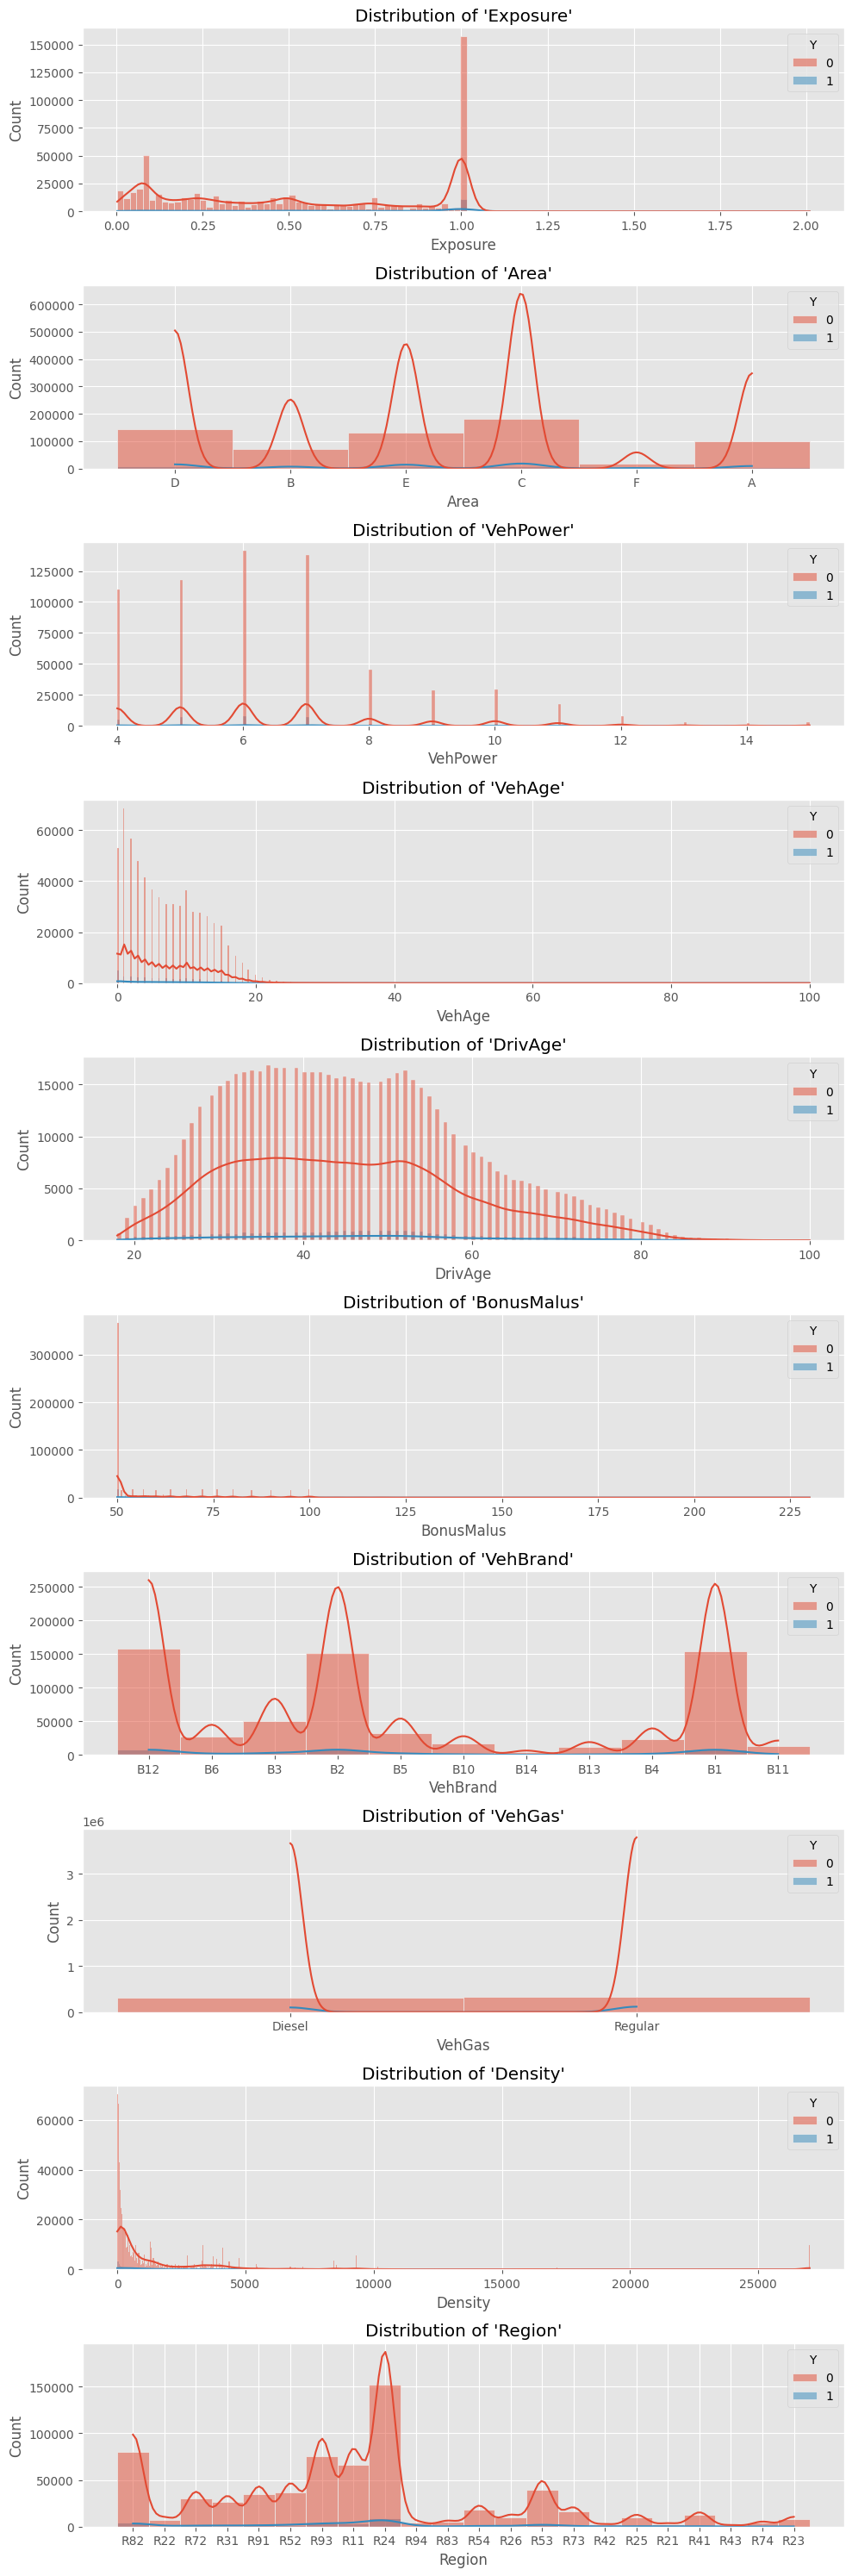

In [13]:
# Check each column but the target Column "Y" distribution based on volume and density 
columns = [col for col in df.columns.tolist() if col != "Y"]

f, axes = plt.subplots(len(columns),1,figsize=(10,30))
for idx,column in enumerate(columns):
    sns.histplot(data=df,x=column,hue='Y',ax=axes[idx],kde=True)
    axes[idx].set_title(f"Distribution of {column!r}")    

plt.tight_layout()
plt.plot()

                
    

Well due to the imbalance of Y's data points (more no claims than claims) we create the plots again but without the different values in 1 plot but in two next to each other

[]

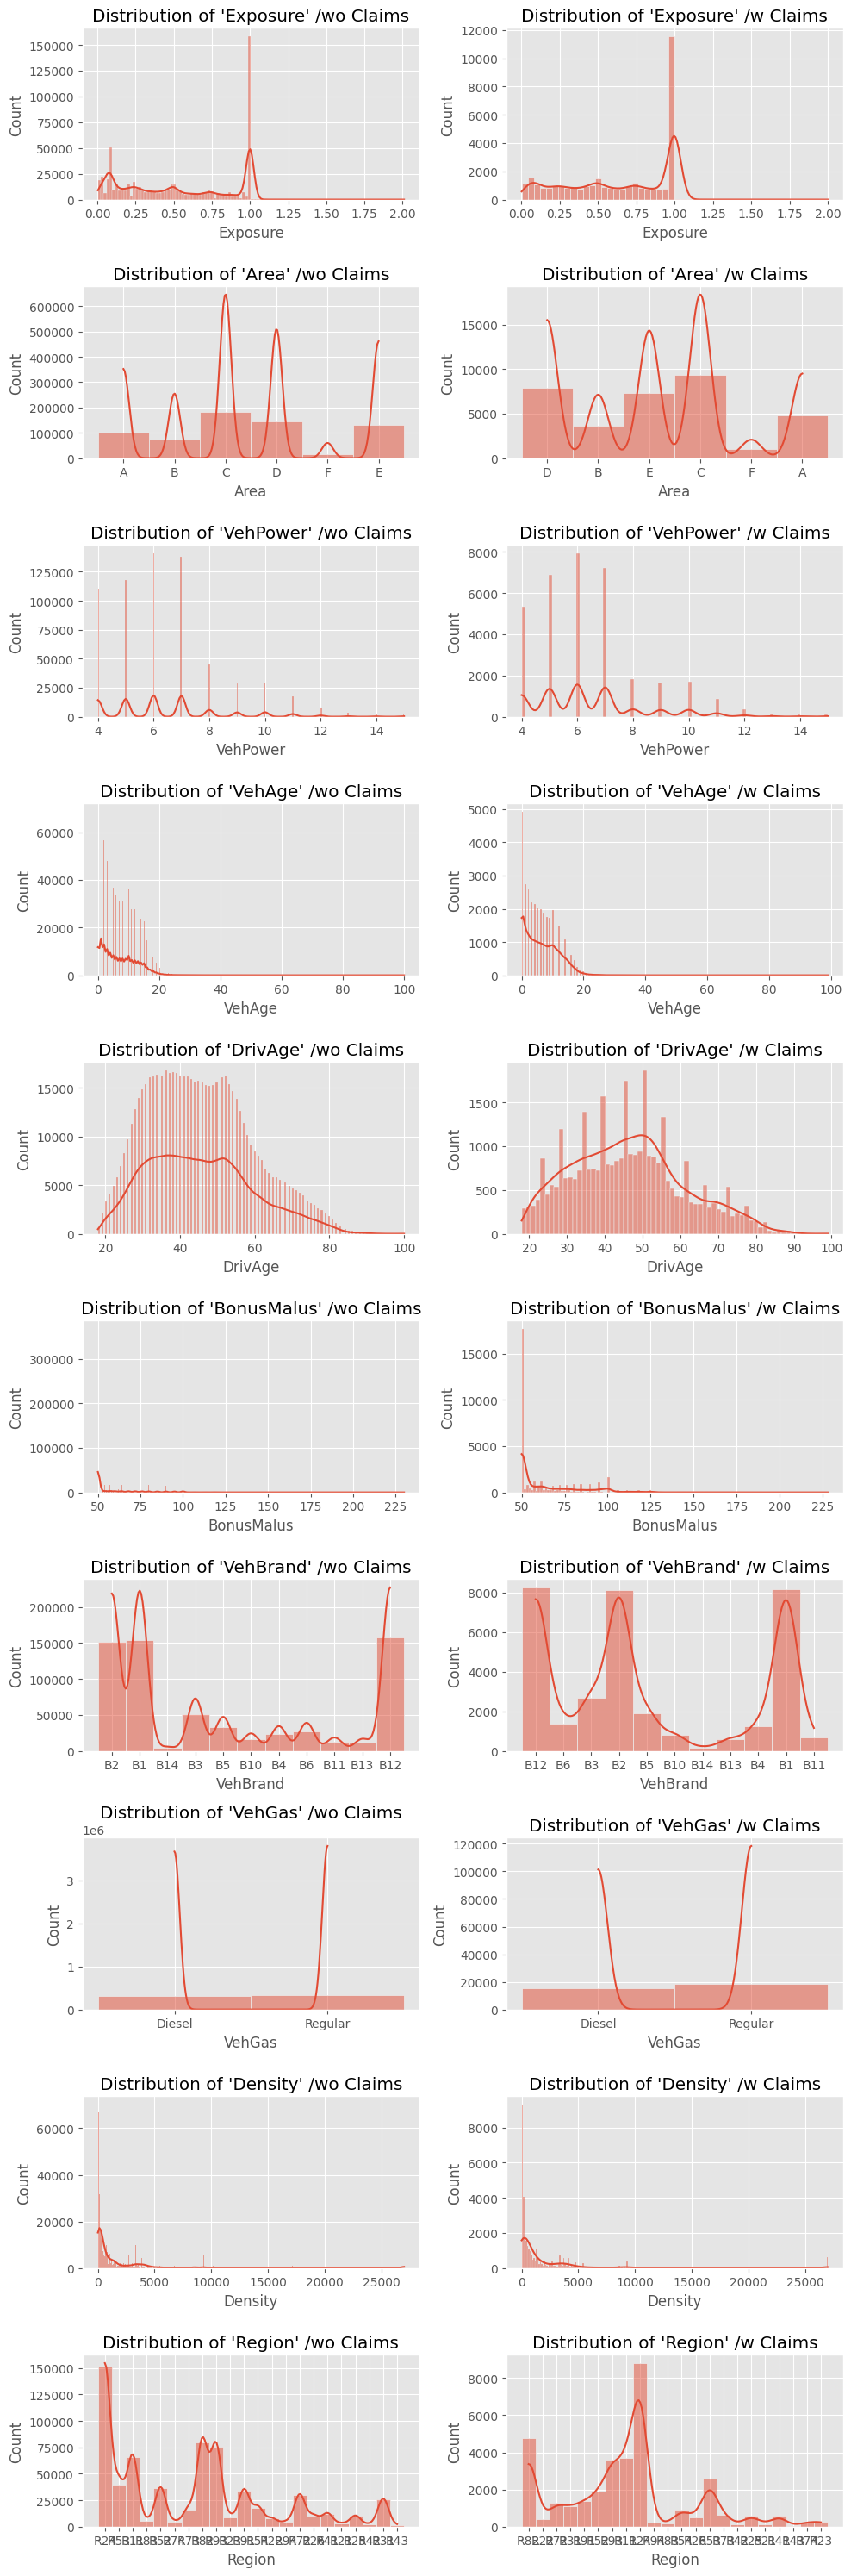

In [14]:
# Check each column but the target Column "Y" distribution based on volume and density 
columns = [col for col in df.columns.tolist() if col != "Y"]

mask = df.Y == 0 
df_no_claim = df.loc[mask]
df_w_claim = df.loc[~mask]
f, axes = plt.subplots(len(columns),2,figsize=(10,30))
for idx,column in enumerate(columns):
    sns.histplot(data=df_no_claim,x=column,ax=axes[idx][0],kde=True)
    sns.histplot(data=df_w_claim,x=column,ax=axes[idx][1],kde=True)
    axes[idx][0].set_title(f"Distribution of {column!r} /wo Claims")    
    axes[idx][1].set_title(f"Distribution of {column!r} /w Claims")    

plt.tight_layout()
plt.plot()

                
    

Now we can have a better look at the distribution of the different values of the feature fields. 
**Interesting** is that in the DrivAge Plot, the data shows a ligh skew to the left (more "younger" people drive a car). However, the public assumption that younger drivers cause more accidents is not shown in the data. 

Another interesting observation is that many accidents happened with rather "new" cars, as shown in the 4th Plot of the feature `VehAge`


The next steps will be to create a pre-processing part that checks all features to see which are good fits for a binary problem described above.
Furthermore, the following steps also cover the transformation of the columns to better fit the models used later on. 

Before we start, I want to showcase a "cool" library that really helps and speeds up this part of the data analysis in the next cell


In [16]:
ProfileReport(df.sample(len(df)//2),dark_mode=True,)  # only take 50% of the data points 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

MemoryError: Unable to allocate 645. TiB for an array with shape (708930691679232,) and data type int8

In [17]:
df.to_pickle("./output/eda.pkl")

<h2 align=middle>Feature Processing </h2>

![FeatureEngineering](https://datascientest.com/de/wp-content/uploads/sites/8/2023/05/feature-engineering.webp)



After the EDA we try to figure out to transform the features in something more useable for the models that will come later.
We will explore Scalings, encodings etc. to tranform our features to something more appropriate for a ml algorithm to work with. 

Afterwards, we will create the baseline model to see how it performs. 



In [58]:
df = pd.read_pickle("./output/eda.pkl") # load the data in 

_ = display(df.head()),display(df.dtypes)

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Y
0,0.10,D,5,0,55,50,B12,Regular,1217,R82,1
1,0.77,D,5,0,55,50,B12,Regular,1217,R82,1
2,0.75,B,6,2,52,50,B12,Diesel,54,R22,1
3,0.09,B,7,0,46,50,B12,Diesel,76,R72,1
4,0.84,B,7,0,46,50,B12,Diesel,76,R72,1


Exposure       float64
Area            object
VehPower         int64
VehAge           int64
DrivAge          int64
BonusMalus       int64
VehBrand        object
VehGas        category
Density          int64
Region          object
Y                int32
dtype: object

## Battle Plan 

- xtract X data (features) and Y data (classes)
- train-test-split the data 
- Try different encoding,scaling methods on the data with the dummy classifier to check which configuration works best 



In [100]:
X = df.loc[:,[col for col in df.columns if col != 'Y']]
y = df.Y 


## Dealing with objects and categories 

- Categories will be encoded using one hot encoding 
- objects with only 2 options will be encoded with 1 and 0 
- objects with more than 2 but less than 5 will be encoded as one hot encoding 
- objects with more or equal than 5 will be encoded wit hthe frequenz encoding 
- numerics will be scaled down with min-max 

In [101]:
def frequenz_encode_series(series:pd.Series)->pd.Series:
    """uses frequenz encoding to encode the data into a numerical representation"""
    
    value_counts = series.value_counts().to_dict()
    series = series.map(value_counts)
    return series
    
    
    
    
    

In [102]:
object_columns = X.select_dtypes(include=['object','category']).columns
object_columns

Index(['Area', 'VehBrand', 'VehGas', 'Region'], dtype='object')

In [103]:
for column in object_columns:
    uniqe_val = X.loc[:,column].unique()
    uniqe_val_count = len(uniqe_val)
    if uniqe_val_count <= 2:
        
        dct = {k:i for i,k in enumerate(uniqe_val)}
        
        X.loc[:,column] = X.loc[:,column].map(dct)
        continue 

    elif 2 < uniqe_val_count < 5:

        hot_enc = OneHotEncoder()
        vals = X.loc[:,column].values 
        new_vals = hot_enc.fit_transform(vals)
        X.loc[:,column] = new_vals 
    else:

        series = X.loc[:,column]
        X.loc[:,column] = frequenz_encode_series(series)

Now, everything should be numeric and can be transformed using the min_max transformer



In [105]:
transform = ColumnTransformer(
    [('min_max',MinMaxScaler(),X.columns)],remainder="passthrough",verbose_feature_names_out=False
)

In [108]:
matrix = transform.fit_transform(X)
X = pd.DataFrame(matrix,columns=transform.get_feature_names_out())

In [119]:
# split it 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=42)

### the features are rdy 2 be used in a ml algorithm 

In [120]:
dummy = DummyClassifier(strategy='stratified',random_state=42)
dummy.fit(X_train,y_train)
print(f"The dummy Scoring is: {dummy.score(X_test,y_test):.4f}")

The dummy Scoring is: 0.9050


In [135]:
print(f"The ROC_AUC is: {roc_auc_score(y_test,dummy.predict(X_test)):.4f}%")

The ROC_AUC is: 0.4997%


In [133]:
knn = KMeans(2,init='random',random_state=42,max_iter=3600,algorithm="elkan")
knn.fit(X_train,y_train)

C:\Users\Benja\Projects\Learning\ds-master-class\datascience-final-project\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(algorithm='elkan', init='random', max_iter=3600, n_clusters=2,
       random_state=42)

In [134]:
yhat = knn.predict(X_test)
print(f"The ROC_AUC is: {roc_auc_score(y_test,yhat):.4f}%")

The ROC_AUC is: 0.5155%


The KNN was 51 % which is slighty better than the dummyclassifier ... lets see if we can get it better with other models

In [138]:
logistic = LogisticRegression(random_state=42,solver="liblinear")
logistic.fit(X_train,y_train)
yhat = logistic.predict(X_test)
print(f"The ROC_AUC is: {roc_auc_score(y_test,yhat):.4f}%")

The ROC_AUC is: 0.5001%


In [141]:
rf = RandomForestClassifier(n_jobs=-1,)
rf.fit(X_train,y_train)
yhat = rf.predict(X_test)
print(f"The ROC_AUC is: {roc_auc_score(y_test,yhat):.4f}%")

The ROC_AUC is: 0.5080%


In [148]:
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be a leaf node
}
grid = GridSearchCV(rf,scoring="roc_auc",param_grid=param_grid )
grid.fit(X_train,y_train)
print(f"Models best score: {grid.best_score_:.4f}")

KeyboardInterrupt: 

In [144]:
grid.best_score_

0.6794867032667243

In [145]:
best_rf = grid.best_estimator_

In [147]:
yhat = best_rf.predict_proba(X_test)
print(f"The ROC_AUC is: {roc_auc_score(y_test,yhat):.4f}%")

The ROC_AUC is: 0.5000%
